The Log-Likelihood function of a binned poisson and gaussian is:

$l(n_i, y_i | \mu_i, s_i, \sigma_i) = \sum_{i=1}^N n_i \log{(\mu_i + s_i)} - N(\mu_i + s_i) -\frac{N}{2} \log{2 \pi \sigma_i^2} - \frac{1}{2}\left( \frac{1}{\sigma_i^2} (y_i - \mu_i)^2 \right)$

Let's split them up into several terms for convenience in computing:

Term 1: $n_i \log{(\mu_i + s_i)}$

Term 2: $ - N(\mu_i + s_i)$

Term 3: $-\frac{N}{2} \log{2 \pi \sigma_i^2}$

Term 4: $- \frac{1}{2}\left( \frac{1}{\sigma_i^2} (y_i - \mu_i)^2 \right)$
    

In [3]:
import autograd.numpy as np
from autograd.numpy import linalg
import matplotlib.pyplot as plt
from autograd.numpy.random import poisson, normal, multivariate_normal
import emcee as mc


%matplotlib inline


def neg_log_like_PGP_bin(mu, s, ni, y, sigma):
    N = len(mu)
    if(len(s)!=N or len(y)!=N or len(ni)!=N or len(sigma)!=N):
        raise ValueError('Input arrays are not all the same length')
    result = 0.
    for i in range(N):
        result += ni[i] * np.log(mu[i] + s[i])
        result += -N*(mu[i] + s[i])
        result += -(N/2) * np.log(2. * np.pi * np.power(sigma[i],2))
        result += -(1./2) *  (np.power((1./sigma[i]),2) * np.power((y[i]-mu[i]),2))
        #result[i] = t1+t2+t3+t4
    return result
    


Similarly, for the multivariate Gaussian case, we can write the log-likelihood function as:

$l(n_i, y_i | \mu_i, s_i, \Sigma) = -\frac{N}{2} \log(2 \pi) - \frac{N}{2} \log{|\Sigma|} - \frac{1}{2} \left( (\vec{y} - \vec{\mu})^T \Sigma^{-1} (\vec{y} - \vec{\mu}) \right) + \sum_{i=1}^N n_i \log{(\mu_i + s_i)} - (\mu_i + s_i)$



In [4]:
def neg_log_like_PGP_MV(mu, s, ni, y, cov, invcov = None):
    if(invcov == None):
        invcov = linalg.inv(cov)
    N = len(mu)
    if(len(s)!=N or len(y)!=N or len(ni)!=N  or cov.shape!=(N,N)):
        raise ValueError('Input arrays are not all the same length')
    t1 = -(N/2.)*np.log(2.*np.pi) - (N/2.) * np.log(linalg.det(cov))
    resid = (y-mu)[np.newaxis]
    t2 = (-(1./2) * np.dot(np.dot(resid,invcov),resid.T))[0][0]
    t3 = 0.
    for i in range(N):
        t3 += ni[i] * np.log(mu[i] + s[i])
        t3 -= (mu[i] + s[i])
    result = t1 + t2 + t3
    if not(np.isfinite(result)):
        return np.infty
    else:
        return -result

def ll(mu, s, ni, y, cov, invcov = None):
    return -neg_log_like_PGP_MV(mu, s, ni, y, cov, invcov = invcov)

def lprior(mu, s, ni, y, cov, invcov = None, bounds = None):
    if bounds!=(None):
        for i in range(len(mu)):
            if(mu[i]<bounds[i][0] or mu[i]>bounds[i][1]):
                return -np.infty
    return 1.
       
def lprob(mu, s, ni, y, cov, invcov = None, bounds = None):
        loglike = ll(mu, s, ni, y, cov, invcov = invcov)
        logprior = lprior(mu, s, ni, y, cov, invcov = invcov, bounds = bounds) 
        #print(str(loglike) + '\t' + str(logprior) + '\n')
        return loglike * logprior


In [5]:
from autograd import grad

nln_bin_grad = grad(neg_log_like_PGP_bin)
nln_MV_grad = grad(neg_log_like_PGP_MV)

In [6]:
def f1(x):
    return (1./(np.exp(x-2)))

def f2(x):
    return 1./x

def f3(x):
    return 1.*np.exp(-3.*(x-0.7))

def f4(x):
    return (1./np.log(x+1))

def f5(x):
    return 1./(np.power(x+.3,2))



Construct kernel of the form:

$\Sigma (x,x') = Ae^{\left(\frac{d-(x+x')}{2a} \frac{-(x-x')^2}{e^{(bx+c)^2} +e^{(bx'+c)^2}}\right)}$

In [9]:
def makekernel(x, k, params, sigma = 0.):
    N = len(x)
    cov = np.empty((N,N))
    if len(sigma) != N:
        sigma = np.zeros(N)
    for i in range(N):
        for j in range(N):
            cov[i][j] = k(x[i],x[j], params)
    if len(sigma)>1:
        for i in range(N):
            cov[i][i] = sigma[i]**2
    return cov

#kernel with constant lengthscale but variable height
def kernel1(x1,x2, params):
    A = params[0]
    a = params[1]
    b = params[2]
    c = params[3]
    d = params[4]
    result = A * np.exp(-(((x1-x2)**2)/(((b*x1 + c)**2)+((b*x2 + c)**2)))+((d-(x1+x2))/(2.*a)))
    return result

#kernel with constant lengthscale but variable height
def kernel2(x1,x2, params):
    A = params[0]
    l = params[1]

    result = A * np.exp(-np.power((x1-x2),2)/(l**2))
    return result

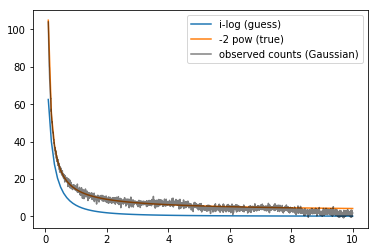

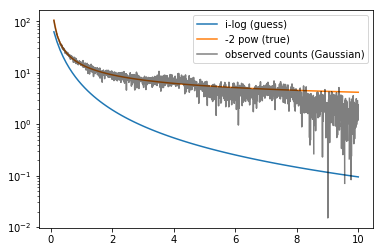

In [26]:
%matplotlib inline
#use odd N, even doesn't work...?
N=1999
x = np.linspace(.1,10,100)
xtrue = np.linspace(.1,10,N)
scale = 1e1
kparams1 = [10., 5., 1., 0., 10.]
kparams2 = [1., 1.]

ymodel = scale * f5(x)
ytrue = scale * f4(x)
ytrue_t = scale * f4(xtrue)
yguess = scale * f4(xtrue)

#cov = makekernel(xtrue, kernel1, kparams1, sigma = np.zeros(N))#np.sqrt(ytrue_t))
cov = makekernel(xtrue, kernel2, kparams2, sigma = np.zeros(N))#np.sqrt(ytrue_t))

#n_G = normal(loc=ytrue_t, scale = np.sqrt(ytrue_t))
n_G = (multivariate_normal(ytrue_t, cov))

yg_up = yguess + 2.*np.sqrt(yguess)
yg_low = yguess - 2.*np.sqrt(yguess)

for i in range(N):
    if yg_low[i]<0.:
        yg_low[i] = 1e-5
boundarray = [(yg_low[i], yg_up[i]) for i in range(N)]
signal0 = np.zeros(N)

#print nln_MV_grad(yguess, signal0, n_G, yguess, cov)

plt.figure()
plt.plot(x,ymodel, label = "i-log (guess)")
plt.plot(x,ytrue, label = "-2 pow (true)")
plt.plot(xtrue,n_G, 'k-', alpha = 0.5, label = "observed counts (Gaussian)")
plt.legend(loc='upper right')

plt.figure()
plt.semilogy(x,ymodel, label = "i-log (guess)")
plt.semilogy(x,ytrue, label = "-2 pow (true)")
plt.semilogy(xtrue,n_G, 'k-', alpha = 0.5, label = "observed counts (Gaussian)")
plt.legend(loc='upper right')

plt.show()

1
[276.86565798   5.35752616   1.15897181   5.40226018]


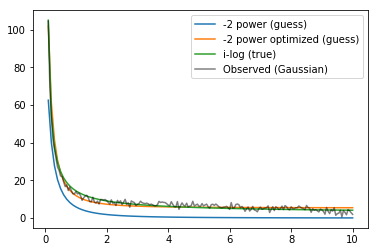

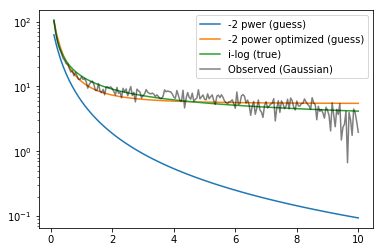

In [23]:
from scipy.optimize import curve_fit

def f4_opt(params, x):
    a = params[0]
    b = params[1]
    c = params[2]
    d = params[3]
    return ((1.*a)/(np.log(b*x + c)))+d

def f5_opt(x, params):
    a, b, c, d = params
    return ((1.*a)/(np.power(b*x + c,2)))+d

def f5_preopt(x, a, b, c, d):
        params = np.array([a,b,c,d])
        return f5_opt(x, params)


p0 = (1., 1., .3, 0)
print len((p0,))
popt, pcov = curve_fit(f5_preopt, x, ytrue, p0=p0)
print popt

ymodel_opt = f5_opt(x, popt)


plt.figure()
plt.plot(x,ymodel, label = "-2 power (guess)")
plt.plot(x,ymodel_opt, label = "-2 power optimized (guess)")
plt.plot(x,ytrue, label = "i-log (true)")
plt.plot(xtrue,n_G,'k-', alpha = 0.5, label = "Observed (Gaussian)")
plt.legend(loc='upper right')

plt.figure()
plt.semilogy(x,ymodel, label = "-2 pwer (guess)")
plt.semilogy(x,ymodel_opt, label = "-2 power optimized (guess)")
plt.semilogy(x,ytrue, label = "i-log (true)")
plt.semilogy(xtrue,n_G,'k-', alpha = 0.5, label = "Observed (Gaussian)")
plt.legend(loc='upper right')

plt.show()

yguess = f5_opt(xtrue, popt)
ymodel = ymodel_opt

In [12]:
'''
nwalker = 2*N
prob = 0
p0_walk = np.array([normal(loc=yguess, scale = np.sqrt(yguess)) for i in range(nwalker)])
burnin = 1
nsteps = 1


sampler = mc.EnsembleSampler(nwalker, N, lprob, args = (signal0, n_G, yguess, cov))#, kwargs={"bounds":boundarray})
print "Burnin..."
p0_walk, prob, _ = sampler.run_mcmc(p0_walk, burnin)

print "Sampling..."
#sampler.reset()
sampler.run_mcmc(p0_walk, nsteps)

print "Done"
chain = sampler.chain
sampler.reset()
print chain.shape
'''

'\nnwalker = 2*N\nprob = 0\np0_walk = np.array([normal(loc=yguess, scale = np.sqrt(yguess)) for i in range(nwalker)])\nburnin = 1\nnsteps = 1\n\n\nsampler = mc.EnsembleSampler(nwalker, N, lprob, args = (signal0, n_G, yguess, cov))#, kwargs={"bounds":boundarray})\nprint "Burnin..."\np0_walk, prob, _ = sampler.run_mcmc(p0_walk, burnin)\n\nprint "Sampling..."\n#sampler.reset()\nsampler.run_mcmc(p0_walk, nsteps)\n\nprint "Done"\nchain = sampler.chain\nsampler.reset()\nprint chain.shape\n'

In [13]:
'''
f, ax = plt.subplots(N, sharex=True, sharey=True, figsize=(20,30))

for j in range(N):
    for i in range(nwalker):
        ax[j].plot(np.arange(burnin + nsteps), chain[i,:,j], 'k-', alpha = 0.1)
plt.show()
'''

"\nf, ax = plt.subplots(N, sharex=True, sharey=True, figsize=(20,30))\n\nfor j in range(N):\n    for i in range(nwalker):\n        ax[j].plot(np.arange(burnin + nsteps), chain[i,:,j], 'k-', alpha = 0.1)\nplt.show()\n"

In [14]:
'''
true_chain = chain[:,burnin:,:]
flat_chain = true_chain.reshape((-1,N))
print flat_chain.shape
mean_mu_g = np.average(flat_chain, axis=0)
print mean_mu_g
'''

'\ntrue_chain = chain[:,burnin:,:]\nflat_chain = true_chain.reshape((-1,N))\nprint flat_chain.shape\nmean_mu_g = np.average(flat_chain, axis=0)\nprint mean_mu_g\n'

In [15]:
'''
nbins = N
max_mu = np.empty(N)
for i in range(N):
    hist, bin_edges = np.histogram(flat_chain[:,i], bins = nbins)
    maxindex = np.argmax(hist)

    max_mu[i] = np.average([bin_edges[maxindex], bin_edges[maxindex+1]])
'''


'\nnbins = N\nmax_mu = np.empty(N)\nfor i in range(N):\n    hist, bin_edges = np.histogram(flat_chain[:,i], bins = nbins)\n    maxindex = np.argmax(hist)\n\n    max_mu[i] = np.average([bin_edges[maxindex], bin_edges[maxindex+1]])\n'

In [16]:
from scipy.optimize import minimize
solnG = minimize(neg_log_like_PGP_MV, yguess,jac = nln_MV_grad, method="L-BFGS-B", args = (signal0, n_G, yguess, cov))# ,bounds = boundarray)

mu_opt_G = solnG.x

print solnG


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


      fun: -204.71048631656868
 hess_inv: <199x199 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.47827901e+00, -6.03594414e-01, -4.71445103e-01, -1.56206347e-01,
       -1.55111722e-01, -1.21617607e-01,  2.37008623e-03, -8.37626162e-02,
       -7.19297482e-02, -4.88900842e-01, -1.09372479e-02, -5.28961441e-02,
        7.21107082e-01,  5.12695295e-02,  5.34226662e-01,  1.39183189e+00,
        3.31261266e-01, -4.68253939e-02,  1.69847779e-01, -1.16939925e+00,
        2.27676785e-01, -1.66682530e-01,  2.54101097e-01,  3.38494897e-01,
        7.65968739e-01,  2.57445793e-01, -2.98136196e-01, -4.65663678e-01,
       -5.31190563e-01,  4.35377047e-01,  1.13301439e-01,  4.61250899e-01,
        5.41494769e-01, -1.42218092e+00, -2.63592769e-01,  2.43427069e-01,
       -8.53540358e-01, -1.15866185e-02,  3.51447795e-01, -1.20966970e-01,
       -1.46537468e+00,  1.12389604e+00, -8.47218586e-01,  2.14466878e-01,
       -1.18237452e+00,  1.70713907e+00, -2.51810039e-01, -3.61076995e-01

In [17]:
'''
import corner
fig = corner.corner(flat_chain, bins=nbins,  truths = solnG[0])

plt.show()
'''

'\nimport corner\nfig = corner.corner(flat_chain, bins=nbins,  truths = solnG[0])\n\nplt.show()\n'

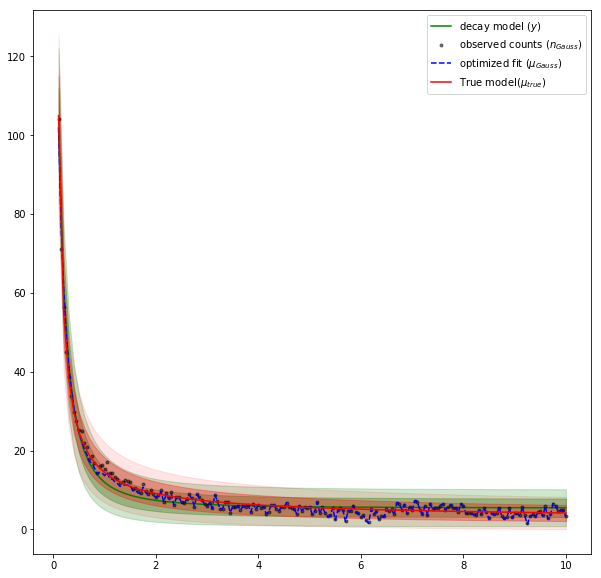

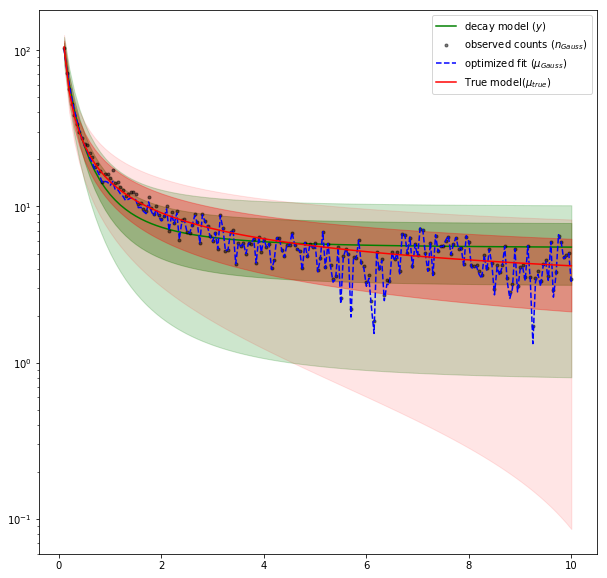

In [18]:
%matplotlib inline
plt.figure()

ym_up = ymodel + 2.*np.sqrt(ymodel)
ym_low = ymodel - 2.*np.sqrt(ymodel)

gp_std = np.sqrt(ymodel)
yguess_std_low = np.empty(len(ymodel))
yguess_std_low2 = np.empty(len(ymodel))
ytrue_std_low = np.empty(len(ymodel))
for i in range(len(ymodel)):
    if ymodel[i]-gp_std[i]<0.1: 
        yguess_std_low[i] = 0.1
    else:
        yguess_std_low[i] = ymodel[i]-gp_std[i]
    if ymodel[i]-2*gp_std[i]<0.1: 
        yguess_std_low2[i] = 0.1
    else:
        yguess_std_low2[i] = ymodel[i]-2*gp_std[i]
    if ytrue[i]-np.sqrt(ytrue[i])<0.1: 
        ytrue_std_low[i] = 0.1
    else:
        ytrue_std_low[i] = ytrue[i]-np.sqrt(ytrue[i])
        
plt.figure(figsize=(10,10))
plt.plot(x, ymodel, 'g-', label = "decay model ($y$)")
plt.fill_between(x, ymodel+gp_std, yguess_std_low, color = 'g', alpha=0.3, edgecolor="none")
plt.fill_between(x, ymodel+2*gp_std, yguess_std_low2, color = 'g', alpha=0.1, edgecolor="none")
plt.fill_between(x, ym_low, ym_up, color = 'g', alpha=0.1, edgecolor="none")
plt.plot(xtrue, n_G,'k.', label = "observed counts ($n_{Gauss}$)", alpha = .5)
plt.plot(xtrue, mu_opt_G,'b--', label = "optimized fit ($\mu_{Gauss}$)")
#plt.plot(xtrue, max_mu, 'y--', label = "emcee mean", alpha = .75)
plt.plot(x, ytrue,'r-', label = "True model($\mu_{true}$)")
plt.fill_between(x, ytrue+np.sqrt(ytrue), ytrue_std_low, color = 'r', alpha=0.3, edgecolor="none")
plt.fill_between(x, ytrue+2*np.sqrt(ytrue), ytrue-2*np.sqrt(ytrue), color = 'r', alpha=0.1, edgecolor="none")
plt.legend(loc="upper right")

plt.figure(figsize=(10,10))
plt.yscale('log')
plt.plot(x, ymodel, 'g-', label = "decay model ($y$)")
plt.fill_between(x, ymodel+gp_std, yguess_std_low, color = 'g', alpha=0.3, edgecolor="none")
plt.fill_between(x, ymodel+2*gp_std, yguess_std_low2, color = 'g', alpha=0.1, edgecolor="none")
plt.fill_between(x, ym_low, ym_up, color = 'g', alpha=0.1, edgecolor="none")
plt.plot(xtrue, n_G,'k.', label = "observed counts ($n_{Gauss}$)", alpha = .5)
plt.plot(xtrue, mu_opt_G,'b--', label = "optimized fit ($\mu_{Gauss}$)")
#plt.plot(xtrue, max_mu, 'y--', label = "emcee mean", alpha = .75)
plt.plot(x, ytrue,'r-', label = "True model($\mu_{true}$)")
plt.fill_between(x, ytrue+np.sqrt(ytrue), ytrue_std_low, color = 'r', alpha=0.3, edgecolor="none")
plt.fill_between(x, ytrue+2*np.sqrt(ytrue), ytrue-2*np.sqrt(ytrue), color = 'r', alpha=0.1, edgecolor="none")
plt.legend(loc="upper right")


plt.show()

In [19]:
xtest = np.array([1., 7.])
y_g = scale*f5(xtest)
y_t = scale*f4(xtest)
n_bin = poisson(y_t)
cov_test = makekernel(xtest, kernel1, kparams, y_t)
print linalg.det(cov_test)
n_gp = n_bin
n_guess = y_t



plt.figure()
plt.plot(x, ytrue, 'r-', label = "True $\mu$")
plt.fill_between(x, ytrue+np.sqrt(ytrue), ytrue-np.sqrt(ytrue), color = 'r', alpha=0.3, edgecolor="none")
plt.plot(x, ymodel, 'g-', label = "Decay Model $y$")
plt.fill_between(x, ymodel+gp_std, ymodel-gp_std, color = 'g', alpha=0.3, edgecolor="none")


plt.plot(xtest, n_gp, 'ko', label = "GP $n_i$")

plt.legend(loc="upper right")

plt.figure()
plt.yscale('log')
plt.plot(x, ytrue, 'r-', label = "True $\mu$")
plt.fill_between(x, ytrue+np.sqrt(ytrue), ytrue-np.sqrt(ytrue), color = 'r', alpha=0.3, edgecolor="none")
plt.plot(x, ymodel, 'g-', label = "Decay Model $y$")
plt.fill_between(x, ymodel+gp_std, yguess_std_low, color = 'g', alpha=0.3, edgecolor="none")


plt.plot(xtest, n_gp, 'ko', label = "GP $n_i$")

plt.legend(loc="upper right")

NameError: name 'kparams' is not defined

In [ ]:
stest = np.array([0.,0.])
ll_true = neg_log_like_PGP_MV(n_gp, stest, n_gp,y_g,cov_test)
ll_0 = neg_log_like_PGP_MV(n_guess, stest, n_gp, y_g, cov_test)
llg_0 = nln_MV_grad(n_guess, stest, n_gp, y_g, cov_test)
bound_test = [(y_g[i]-2*np.sqrt(y_g[i]),y_g[i]+2*np.sqrt(y_g[i])) for i in range(2)]

x3d = []
y3d = []
z3d = []
z3d_gradx = []
z3d_grady = []


        
   
soln_test = fmin_l_bfgs_b(neg_log_like_PGP_MV, [n_guess], fprime=nln_MV_grad, approx_grad = False, bounds = bound_test, args = (stest, n_gp, y_g, cov_test), epsilon = np.finfo(float).eps, factr = 10., pgtol=1e-8)

print soln_test[2]

# use this for COBYLA soln_test.x=soln_test.x[0]

mu1_opt = soln_test[0][0]
mu2_opt = soln_test[0][1]
ll_opt = soln_test[1]

plot_range = 10.

if mu1_opt<plot_range:
    mu1_low = 1e-5
else:
    mu1_low = mu1_opt-plot_range

if mu2_opt<plot_range:
    mu2_low = 1e-5
else:
    mu2_low = mu2_opt-plot_range

for mu1 in np.linspace(mu1_low,mu1_opt+plot_range, 30):
    for mu2 in np.linspace(mu2_low,mu2_opt+plot_range, 30):
        x3d.append(mu1)
        y3d.append(mu2)
        mutest = np.array([mu1,mu2])
        ll_temp = neg_log_like_PGP_MV(mutest, stest, n_gp, y_g, cov_test)
        ll_grad = nln_MV_grad(mutest, stest, n_gp, y_g, cov_test)
        z3d.append(ll)
        z3d_gradx.append(ll_grad[0])
        z3d_grady.append(ll_grad[1])
   


In [ ]:
print nln_MV_grad(soln_test[0], stest, n_gp, y_g, cov_test)
print np.linalg.norm(nln_MV_grad(soln_test[0], stest, n_gp, y_g, cov_test))


In [ ]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

x3d = np.array(x3d)
y3d = np.array(y3d)
z3d = np.array(z3d)

fig = plt.figure()
ax = fig.gca(projection='3d')

ax.set_xlabel('$\mu_1$ (at x=' + str(xtest[0])+')')
ax.set_ylabel('$\mu_2$ (at x=' + str(xtest[1])+')')
ax.set_zlabel('Log-Likelihood')

#.plot_trisurf(x3d,y3d,z3d)
ax.plot([n_gp[0]],[n_gp[1]],[ll_true],'k.')
ax.plot([n_guess[0]],[n_guess[1]], [ll_0], 'r.')
ax.plot([mu1_opt],[mu2_opt], [ll_opt], 'b.')
plt.show()

In [ ]:
plt.figure()

z3d_gradx_a= np.array(z3d_gradx)
z3d_grady_a= np.array(z3d_grady)

z3d_gradx_log = np.sign(z3d_gradx_a) * np.log(abs(z3d_gradx_a)+1.)
z3d_grady_log = np.sign(z3d_grady_a) * np.log(abs(z3d_grady_a)+1.)


plt.quiver(x3d,y3d,z3d_gradx_log,z3d_grady_log)#, scale=1e3)
plt.plot([n_gp[0]],[n_gp[1]],'k.')
plt.plot([n_guess[0]],[n_guess[1]], 'r.')
plt.plot([mu1_opt],[mu2_opt],  'b.')
plt.xlabel('$\mu_1$ (at x=' + str(xtest[0])+')')
plt.ylabel('$\mu_2$ (at x=' + str(xtest[1])+')')
plt.show()

In [ ]:
plt.figure()
plt.plot(xtest, soln_test[0], 'bo', label = "Optimized Result")
plt.plot(x, ytrue, 'r-', label = "True $\mu$")
plt.fill_between(x, ytrue+2*np.sqrt(ytrue), ytrue-2*np.sqrt(ytrue), color = 'r', alpha=0.1, edgecolor="none")
plt.fill_between(x, ytrue+np.sqrt(ytrue), ytrue-np.sqrt(ytrue), color = 'r', alpha=0.3, edgecolor="none")
plt.plot(x, ymodel, 'g-', label = "Decay Model $y$")
plt.fill_between(x, ymodel+gp_std, ymodel-gp_std, color = 'g', alpha=0.3, edgecolor="none")


plt.plot(xtest, n_gp, 'ko', label = "Observed Counts $n_i$")

plt.legend(loc="upper right")

plt.figure()
plt.yscale('log')
plt.plot(xtest, soln_test[0], 'bo', label = "Optimized Result")
plt.plot(x, ytrue, 'r-', label = "True $\mu$")
plt.fill_between(x, ytrue+2*np.sqrt(ytrue), ytrue-2*np.sqrt(ytrue), color = 'r', alpha=0.1, edgecolor="none")
plt.fill_between(x, ytrue+np.sqrt(ytrue), ytrue-np.sqrt(ytrue), color = 'r', alpha=0.3, edgecolor="none")
plt.plot(x, ymodel, 'g-', label = "Decay Model $y$")
plt.fill_between(x, ymodel+gp_std, yguess_std_low, color = 'g', alpha=0.3, edgecolor="none")


plt.plot(xtest, n_gp, 'ko', label = "Observed Counts $n_i$")

plt.legend(loc="upper right")

plt.show()